Loaded X.npy (shape=(1571, 704)) and y.npy (shape=(1571,))
Class distribution (label: count): {np.int64(0): np.int64(744), np.int64(1): np.int64(827)}
Train shape: (1256, 704), Test shape: (315, 704)
Random Forest classifier training complete.
Test Accuracy: 0.8190
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       149
           1       0.84      0.81      0.83       166

    accuracy                           0.82       315
   macro avg       0.82      0.82      0.82       315
weighted avg       0.82      0.82      0.82       315



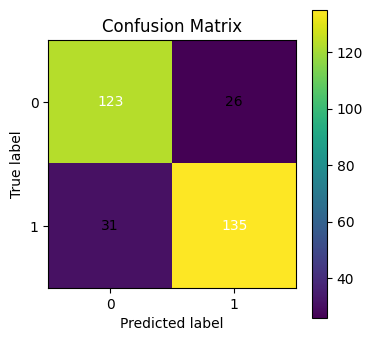

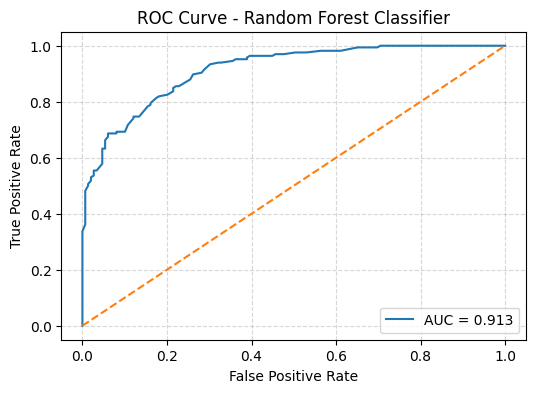

Top 10 feature importances:
1. Feature 553 importance: 0.0178
2. Feature 409 importance: 0.0177
3. Feature 585 importance: 0.0145
4. Feature 519 importance: 0.0140
5. Feature 574 importance: 0.0117
6. Feature 563 importance: 0.0116
7. Feature 497 importance: 0.0113
8. Feature 630 importance: 0.0110
9. Feature 619 importance: 0.0108
10. Feature 618 importance: 0.0107


In [1]:
import os
import numpy as np

# Try importing sklearn components
try:
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
except ImportError as e:
    raise ImportError("scikit-learn is required for this cell. Please install it (e.g., `pip install scikit-learn`).") from e

import matplotlib.pyplot as plt

# Load or construct feature matrix X and binary labels y
if os.path.exists("X.npy") and os.path.exists("y.npy"):
    X = np.load("X.npy")
    y = np.load("y.npy")
    print(f"Loaded X.npy (shape={X.shape}) and y.npy (shape={y.shape})")
else:
    # Fallback: load training_data.npy and construct X, y
    file_path = "training_data.npy"
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Neither X.npy/y.npy nor {file_path} found in current directory.")
    data = np.load(file_path, allow_pickle=True)
    print(f"Loaded {len(data)} entries from {file_path}; constructing X and y...")
    # infer feature size from first entry
    first_entry = data[0]
    if len(first_entry) < 3 or not isinstance(first_entry[2], np.ndarray):
        raise ValueError("Unexpected entry format in training_data.npy")
    n_features = first_entry[2].size
    n_samples = len(data)
    X = np.zeros((n_samples, n_features), dtype=float)
    y = np.zeros(n_samples, dtype=int)
    for idx, entry in enumerate(data):
        _, labels, patch_flat = entry
        # Features: flatten and replace NaN
        arr = np.nan_to_num(patch_flat, nan=0.0)
        if arr.size != n_features:
            raise ValueError(f"Inconsistent feature size at index {idx}: {arr.size} vs expected {n_features}")
        X[idx, :] = arr
        # Binary label: total microcystin > 0.1 µg/L
        if labels is None or len(labels) < 2:
            total = 0.0
        else:
            part = labels[0] if not np.isnan(labels[0]) else 0.0
            diss = labels[1] if not np.isnan(labels[1]) else 0.0
            total = part + diss
        y[idx] = 1 if total > 0.1 else 0
    print(f"Constructed X (shape={X.shape}) and y (distribution: {np.bincount(y)})")
    # Optionally save for future use
    np.save("X.npy", X)
    np.save("y.npy", y)
    print("Saved X.npy and y.npy for future runs.")

# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class distribution (label: count):", dict(zip(unique, counts)))

# Split into train/test with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Note: Random Forest does not require feature scaling.

# Train Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)
print("Random Forest classifier training complete.")

# Predict on test set
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.xticks([0, 1])
plt.yticks([0, 1])
# Annotate counts
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

# ROC curve and AUC (if both classes present in test set)
if len(np.unique(y_test)) == 2:
    y_prob = rf_clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Random Forest Classifier")
    plt.legend(loc="lower right")
    plt.grid(True, ls='--', alpha=0.5)
    plt.show()
else:
    print("Cannot plot ROC: only one class present in y_test.")

# Feature importance (if dimensionality manageable)
importances = rf_clf.feature_importances_
# Show top N features
N = 10
idx_sorted = np.argsort(importances)[::-1][:N]
print(f"Top {N} feature importances:")
for rank, idx_feat in enumerate(idx_sorted, start=1):
    print(f"{rank}. Feature {idx_feat} importance: {importances[idx_feat]:.4f}")
